# Rossmann Store Sales:
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

In [1]:
#Importing relevant libraries and tools for this analysis

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore', '.* .*')

<ipython-input-1-100152552406>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# connecting to google drive to get the required file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing the details of stores
store_data = pd.read_csv('/content/drive/MyDrive/Upgrad/CAPStone/Final Project/store.csv')
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
print('Total no of stores : ',len(store_data))

Total no of stores :  1115


In [5]:
#Importing the sales data for all the stores
sales_data = pd.read_csv('/content/drive/MyDrive/Upgrad/CAPStone/Final Project/train.csv')
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
#Defining plots for univariate EDA
def plot_univar(series,kind='bar'):
    ax=series.plot(kind=kind)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.005))
    plt.legend(loc='best')
    plt.show()

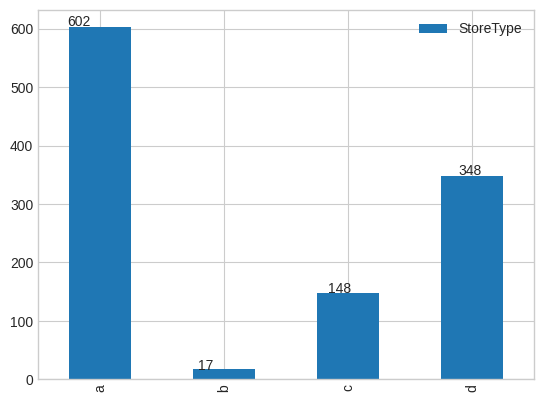

In [ ]:
plot_univar(store_data['StoreType'].value_counts().sort_index())

**Maximum type of store is of A type**

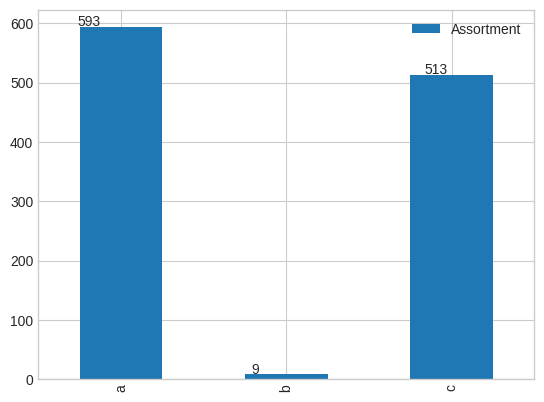

In [7]:
plot_univar(store_data['Assortment'].value_counts().sort_index())

**There are very few b type assortment. a and c type assortment are almost similar in no.**

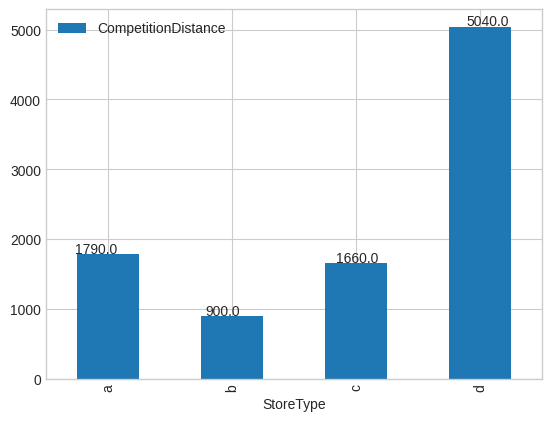

In [8]:
plot_univar(store_data.groupby('StoreType')['CompetitionDistance'].median())

**D** type stores has the maximum competition distance

In [9]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

## Replacing null values

In [10]:
#Replacing the competition parameters with the median and mode(wherever applicable)
store_data.CompetitionDistance.fillna(store_data.CompetitionDistance.median(),inplace=True)
store_data.CompetitionOpenSinceMonth.fillna(store_data.CompetitionOpenSinceMonth.mode().values[0],inplace=True)
store_data.CompetitionOpenSinceYear.fillna(store_data.CompetitionOpenSinceYear.mode().values[0],inplace=True)

In [ ]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
print ('The no of stores running the second promotion :',store_data.Promo2.sum())

The no of stores running the second promotion : 571


In [12]:
store_data[store_data.Promo2==0].isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

All the stores having no Promo2 has the null values for all the Promo2 related attributes

In [13]:
print('Total no of sales entry for all the stores is :',len(sales_data))

Total no of sales entry for all the stores is : 1017209


In [14]:
sales_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [15]:
sales_data.groupby('Store').Sales.count().value_counts()

942    934
758    180
941      1
Name: Sales, dtype: int64

934 stores has data for 942 days, 180 stores has the data for 758 days, 1 store has data for 941 days

## Sales Distribution

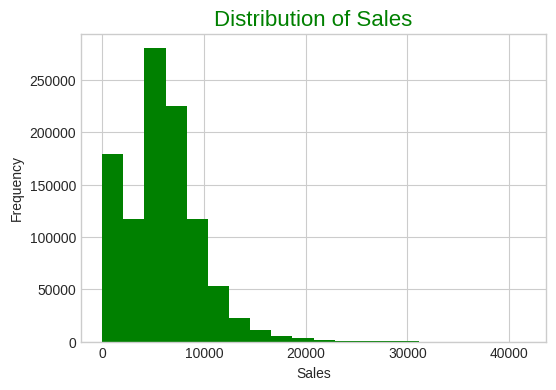

In [16]:
#plot_univar(sales_data.Sales,kind='hist')

plt.figure(figsize=(6, 4))
plt.title("Distribution of Sales", fontsize=16, color='green')
plt.hist(sales_data.Sales, color='green', bins=20)
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

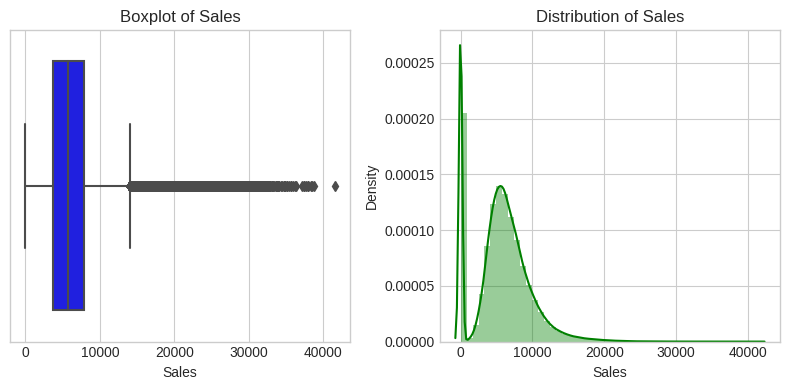

In [17]:
plt.figure(figsize=(8, 4))

# Horizontal Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=sales_data.Sales, color='blue', orient='h')
plt.xlabel("Sales")
plt.title("Boxplot of Sales")

# Distribution Plot
plt.subplot(1, 2, 2)
sns.distplot(sales_data.Sales, color='green')
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Distribution of Sales")

plt.tight_layout()
plt.show()

Except the zeros. The data looks a bit right skewed due to few outliers

In [18]:
sales_data.Sales.describe([0.25,0.5,0.75,0.99])

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
99%      1.716000e+04
max      4.155100e+04
Name: Sales, dtype: float64

In [19]:
sales_data.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

## Sales per customer

In [20]:
sales_data['SalePerCustomer']=sales_data.Sales/sales_data.Customers
sales_data['SalePerCustomer'].describe([0.25,0.5,0.75,0.99])

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
99%          15.193987
max          64.957854
Name: SalePerCustomer, dtype: float64

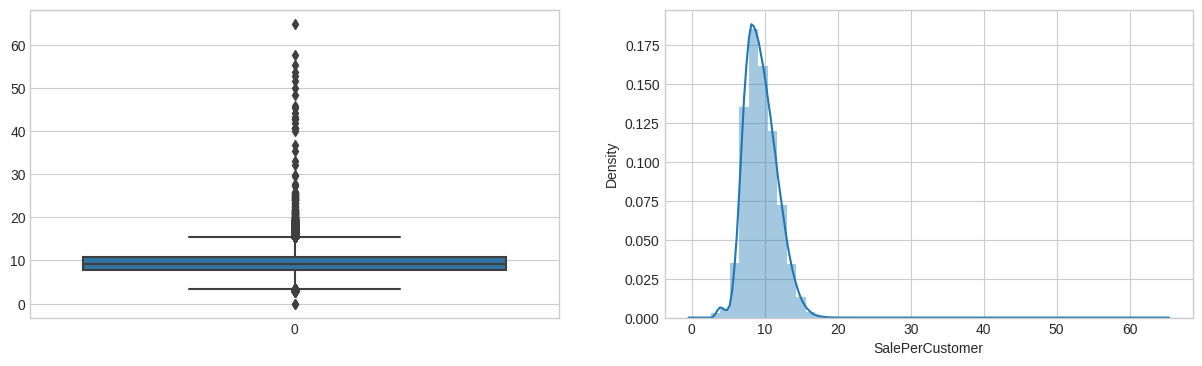

In [21]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.boxplot(sales_data.SalePerCustomer)
plt.subplot(1, 2, 2)
sns.distplot(sales_data.SalePerCustomer)
plt.show()

The data is a bit right skewed. Removing the data above 99 percentile

In [22]:
store_sales_data = sales_data[~(sales_data['SalePerCustomer']>15.19)]
store_sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118


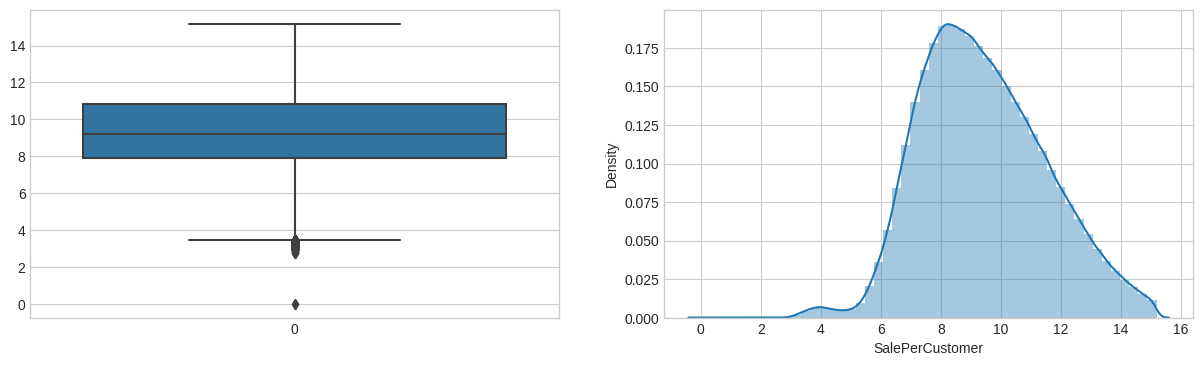

In [23]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.boxplot(store_sales_data.SalePerCustomer)
plt.subplot(1, 2, 2)
sns.distplot(store_sales_data.SalePerCustomer)
plt.show()

Now the data is almost centred normally distributed

In [24]:
print('Total no of remaining data:',len(store_sales_data))

Total no of remaining data: 1008737


## Analyzing sales wrt week days

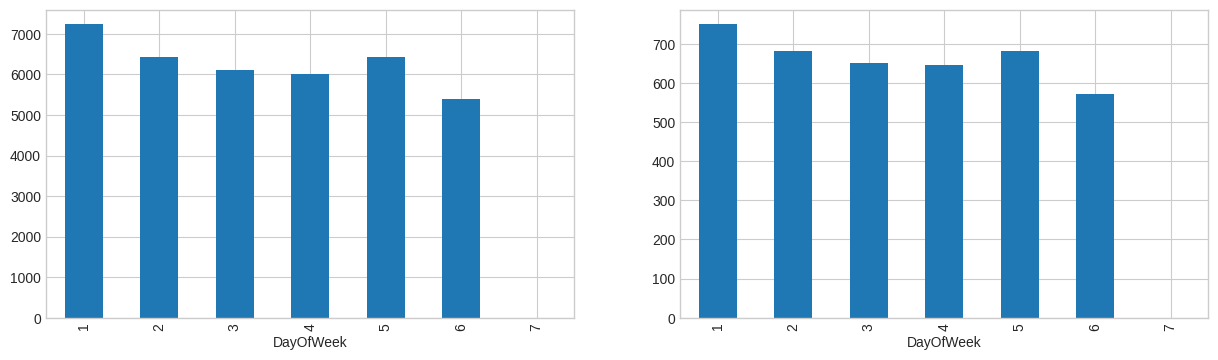

In [25]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
store_sales_data.groupby('DayOfWeek').Sales.median().plot(kind='bar')
plt.subplot(1, 2, 2)
store_sales_data.groupby('DayOfWeek').Customers.median().plot(kind='bar')
plt.show()

Sales is maximum just after the weekends.

## Creating Days Months and Year column

In [26]:
store_sales_data['Date'] = pd.to_datetime(store_sales_data['Date'],format='%Y-%m-%d')
store_sales_data['Day'] = store_sales_data['Date'].dt.day
store_sales_data['Month'] = store_sales_data['Date'].dt.month
store_sales_data['Year'] = store_sales_data['Date'].dt.year
store_sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,31,7,2015


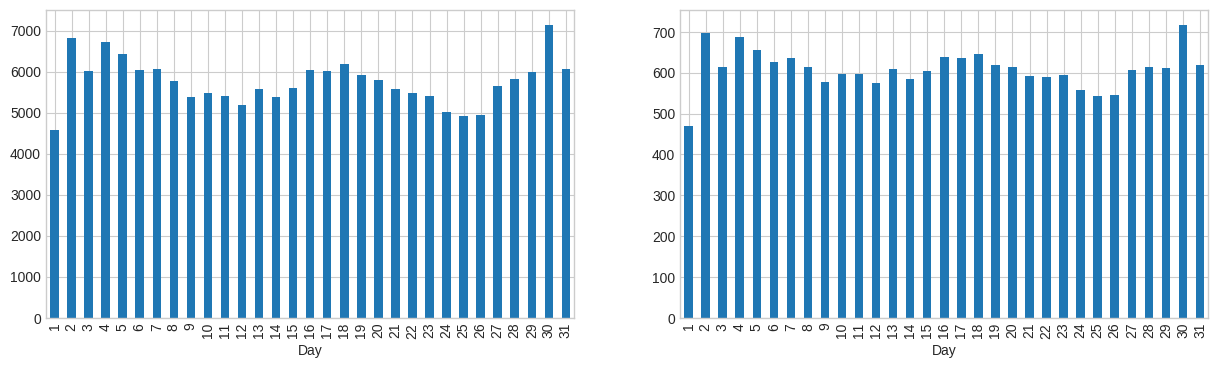

In [27]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
store_sales_data.groupby('Day').Sales.median().plot(kind='bar')
plt.subplot(1, 2, 2)
store_sales_data.groupby('Day').Customers.median().plot(kind='bar')
plt.show()

Sale is high during **start** and **end** of the month and also at mid of the month

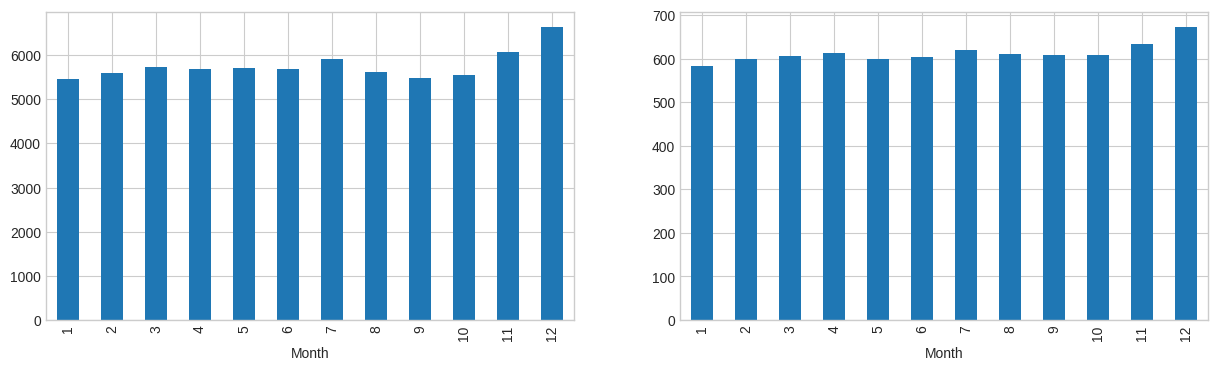

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
store_sales_data.groupby('Month').Sales.median().plot(kind='bar')
plt.subplot(1, 2, 2)
store_sales_data.groupby('Month').Customers.median().plot(kind='bar')
plt.show()

Maximum sales is around **December** month which might be due to the festive season

<Axes: xlabel='Promo'>

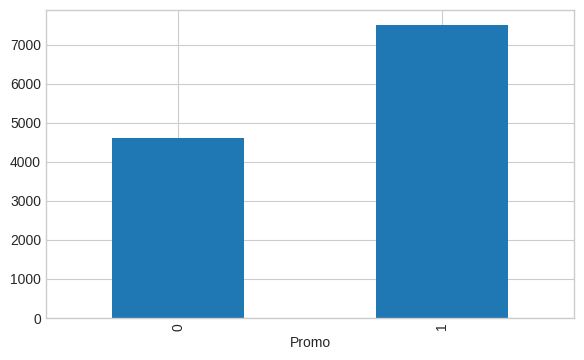

In [29]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
store_sales_data.groupby('Promo').Sales.median().plot(kind='bar')

In [ ]:
print(store_sales_data[store_sales_data.StateHoliday.isin(['a','b','c'])].Sales.describe())

count    31047.000000
mean       257.152446
std       1810.785951
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      38722.000000
Name: Sales, dtype: float64


<Axes: xlabel='SchoolHoliday'>

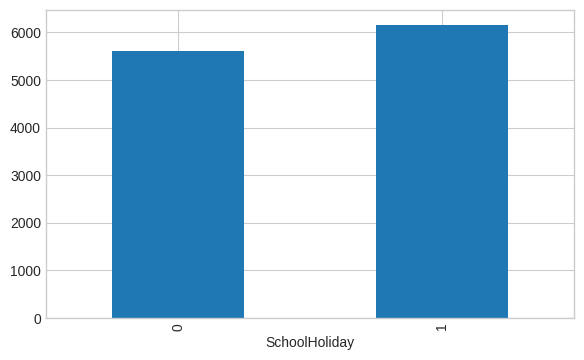

In [30]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
store_sales_data.groupby('SchoolHoliday').Sales.median().plot(kind='bar')

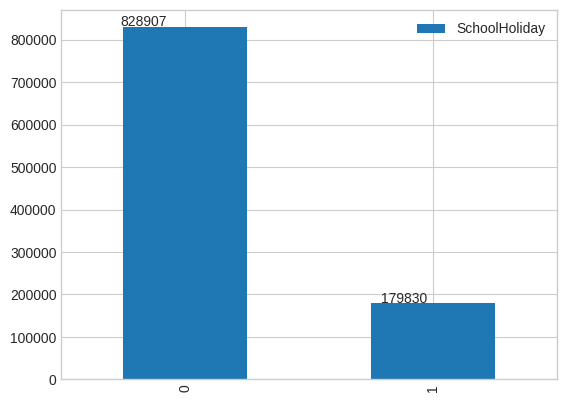

In [31]:
plot_univar(store_sales_data.SchoolHoliday.value_counts())

18% of the data entries are schoolHoliday

Sales during school holidays are a little bit higher than the normal days

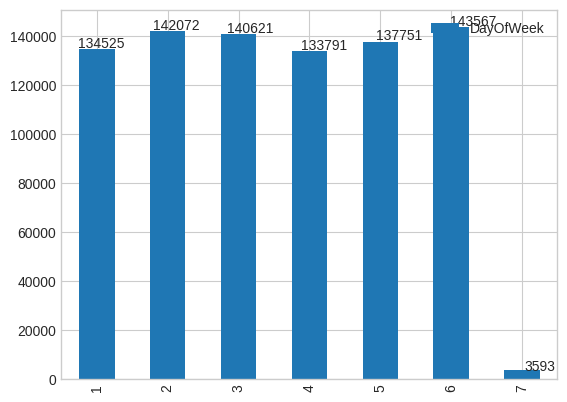

In [32]:
plot_univar(store_sales_data[store_sales_data.Open!=0].DayOfWeek.value_counts().sort_index())

Most of the Sundays stores are closed

In [33]:
store_data.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [34]:
#Add the Promo2 thing here
store_data.PromoInterval=store_data.PromoInterval.apply(lambda x:[0] if pd.isna(x) else x.split(','))

In [ ]:
store_data.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

## Splitting data into 9 stores

Scope of analysis is for store no ***1,3,8,9,13,25,29,31 and 46***

In [35]:
ls = [1,3,8,9,13,25,29,31,46]#list of stores to be analyzed
store_data=store_data[store_data['Store'].isin(ls)]
store_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,[0]
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]"
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,[0]
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,[0]
12,13,d,a,310.0,9.0,2013.0,1,45.0,2009.0,"[Feb, May, Aug, Nov]"
24,25,c,a,430.0,4.0,2003.0,0,NaN,NaN,[0]
28,29,d,c,2170.0,9.0,2013.0,0,NaN,NaN,[0]
30,31,d,c,9800.0,7.0,2012.0,0,NaN,NaN,[0]
45,46,c,a,1200.0,9.0,2005.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]"


Since we would be analyzing each store individually, CompetitionDistance would not matter much. But we will create a variable for when Competition opened because it would have affected the sales.

## Creating Competitionopen date variable

In [36]:
store_data['CompetitionOpenSince'] = store_data['CompetitionOpenSinceMonth'].apply(lambda x:str(int(x)))+'-'+store_data['CompetitionOpenSinceYear'].apply(lambda x:str(int(x)))
store_data['CompetitionOpenSince']= pd.to_datetime(store_data['CompetitionOpenSince'])
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,[0],2008-09-01
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2006-12-01
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,[0],2014-10-01
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,[0],2000-08-01
12,13,d,a,310.0,9.0,2013.0,1,45.0,2009.0,"[Feb, May, Aug, Nov]",2013-09-01


In [37]:
# Scope of analysis is for store no 1,3,8,9,13,25,29,31 and 46
ls = [1,3,8,9,13,25,29,31,46]#list of stores to be analyzed
store_sales_data=store_sales_data[store_sales_data['Store'].isin(ls)]
#store_data = store_data.set_index('Store')
store_sales_data.head()

### Analyzing the variables of store dataset

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,31,7,2015
7,8,5,2015-07-31,8492,833,1,1,0,1,10.194478,31,7,2015
8,9,5,2015-07-31,8565,687,1,1,0,1,12.467249,31,7,2015
24,25,5,2015-07-31,14180,1586,1,1,0,1,8.940731,31,7,2015


In [38]:
store_sales_data['PromoInterval']=store_sales_data.Store.apply(lambda x:store_data[store_data['Store']==x]['PromoInterval'].values[0])

In [39]:
#Converting month format to match with PromoInterval
store_sales_data.Month=store_sales_data.Date.dt.strftime('%b')
#store_sales_data.head()

In [40]:
#Adding promo2 variable for respective month
store_sales_data['Promo2a']=store_sales_data.apply(lambda x:1 if x.Month in x.PromoInterval else 0,axis=1)
#store_sales_data.head()

In [41]:
#g Adding CompetitionSince variable for dates competition is there in the market
store_sales_data['CompetitionSince']=store_sales_data.Store.apply(lambda x:store_data[store_data.Store==x]['CompetitionOpenSince'].values[0])
store_sales_data['CompetitionSince']=store_sales_data.apply(lambda x:1 if x.Date>=x.CompetitionSince else 0,axis=1)
#store_sales_data.head()

<Axes: >

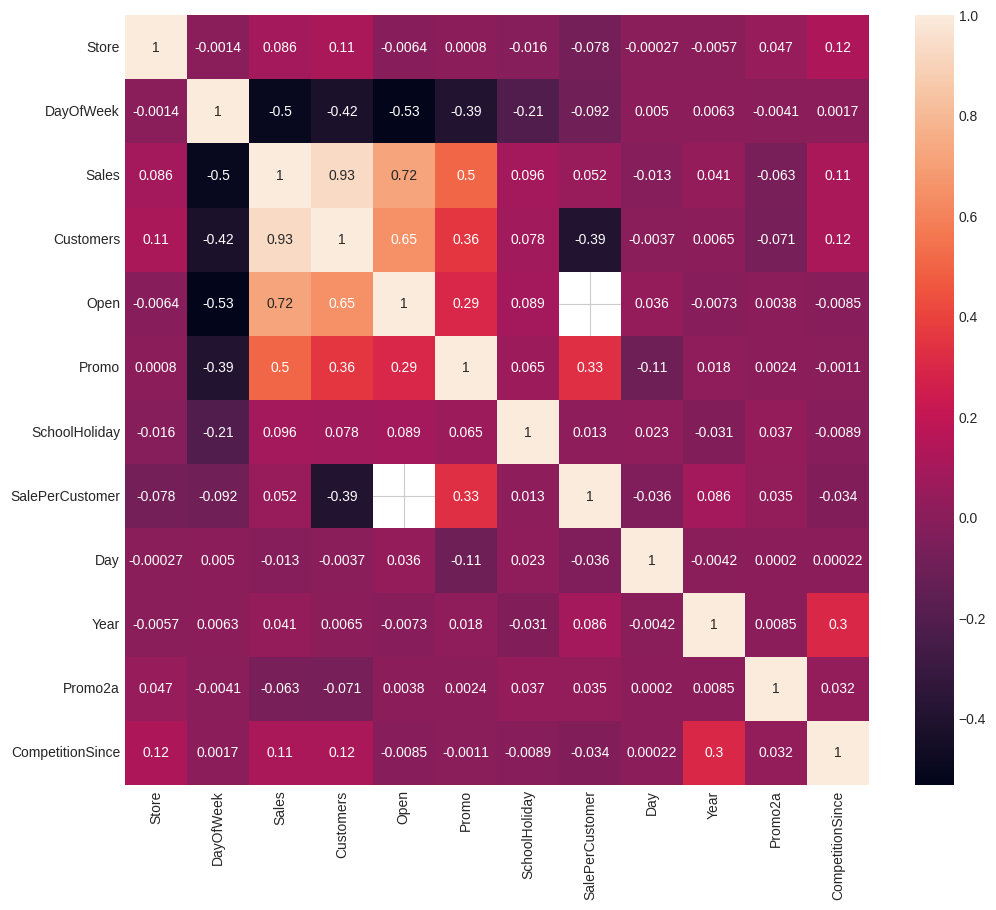

In [42]:
plt.figure(figsize=(12,10))
sns.heatmap(store_sales_data.corr(),annot=True)

There is a high correlation of sales with the **no of customers**. Also there is a good correlation of sales with open and promo.

## Creating dummies for categorical variable

In [43]:
df=pd.get_dummies(store_sales_data.DayOfWeek,prefix='DayOfWeek')
store_sales_data = pd.concat([store_sales_data,df],axis=1)
store_sales_data.drop('DayOfWeek',axis=1,inplace=True)
store_sales_data.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,Day,Month,Year,PromoInterval,Promo2a,CompetitionSince,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1,2015-07-31,5263,555,1,1,0,1,9.482883,31,Jul,2015,[0],0,1,0,0,0,0,1,0,0
2,3,2015-07-31,8314,821,1,1,0,1,10.126675,31,Jul,2015,"[Jan, Apr, Jul, Oct]",1,1,0,0,0,0,1,0,0
7,8,2015-07-31,8492,833,1,1,0,1,10.194478,31,Jul,2015,[0],0,1,0,0,0,0,1,0,0
8,9,2015-07-31,8565,687,1,1,0,1,12.467249,31,Jul,2015,[0],0,1,0,0,0,0,1,0,0
24,25,2015-07-31,14180,1586,1,1,0,1,8.940731,31,Jul,2015,[0],0,1,0,0,0,0,1,0,0


In [44]:
store_sales_data.StateHoliday.value_counts()

0    6794
0    1019
a     163
b      54
c      32
Name: StateHoliday, dtype: int64

There are two types of zeros one in numeric format and one in the string format. Converting the numeric format into the string format.

In [45]:
df=pd.get_dummies(store_sales_data.StateHoliday,prefix='StateHoliday')
df.drop('StateHoliday_0',axis=1,inplace=True)
store_sales_data = pd.concat([store_sales_data,df],axis=1)
store_sales_data.drop('StateHoliday',axis=1,inplace=True)
#store_sales_data.head(10)

<Axes: >

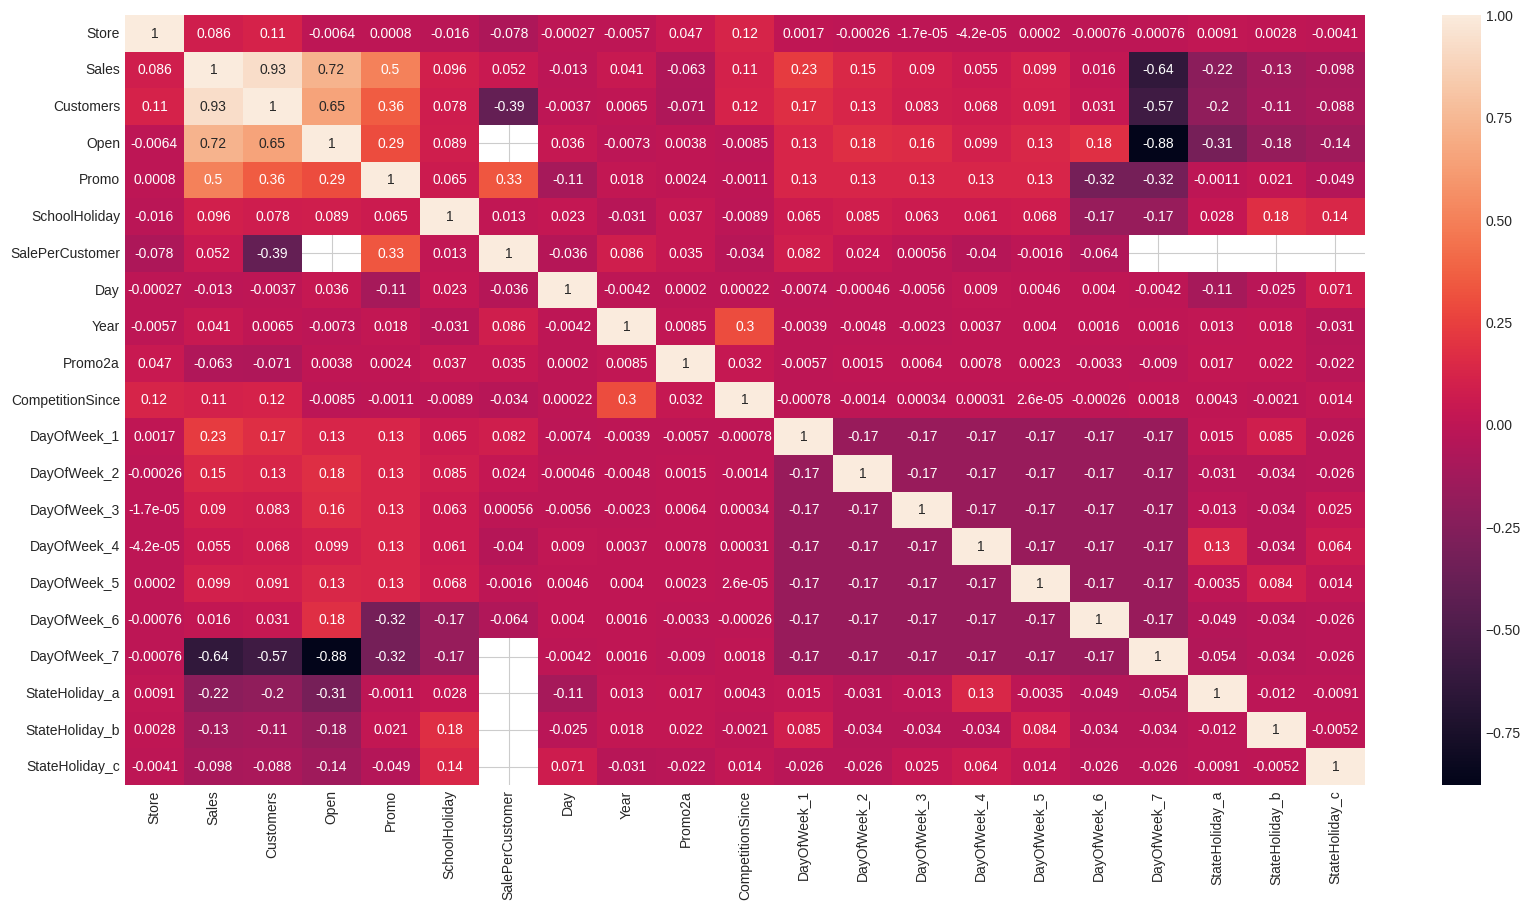

In [46]:
plt.figure(figsize=(20,10))
sns.heatmap(store_sales_data.corr(),annot=True)

Correlation similar to previous heatmap is observed

In [47]:
#Dropping extra variables
store_sales_data.drop(['SalePerCustomer','Day','Month','Year','PromoInterval'],axis=1,inplace=True)

In [48]:
store_sales_data.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,Promo2a,CompetitionSince,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,2015-07-31,5263,555,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0
2,3,2015-07-31,8314,821,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0
7,8,2015-07-31,8492,833,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0
8,9,2015-07-31,8565,687,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0
24,25,2015-07-31,14180,1586,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0


<Axes: xlabel='Sales', ylabel='Density'>

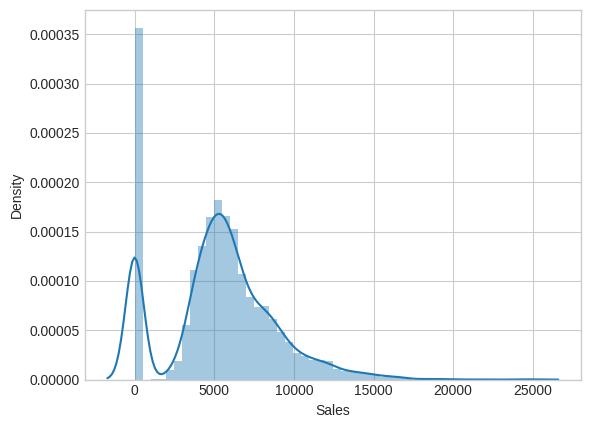

In [49]:
sns.distplot(store_sales_data.Sales)

<Axes: xlabel='Sales', ylabel='Density'>

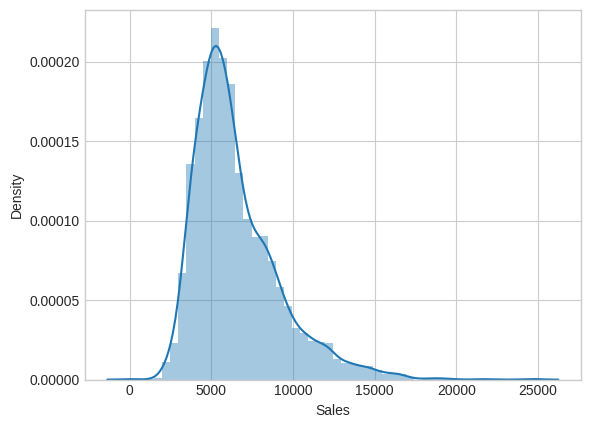

In [50]:
store_sales_data_open = store_sales_data[store_sales_data.Open!=0]
sns.distplot(store_sales_data_open.Sales)

In [51]:
#splitting the data for 9 stores
store={}
for i in ls:
    store[i]=store_sales_data[store_sales_data['Store']==i]
    #store_open[i]['Date']=pd.to_datetime(store[i]['Date'],format='%Y-%m-%d')
    store[i].set_index('Date',inplace=True)
    store[i].sort_index(inplace=True)
    #store[i].index = pd.DatetimeIndex(store[i].index).to_period('D')
for i in ls:
    print('Store no.',i,':',store[i].shape)

Store no. 1 : (942, 18)
Store no. 3 : (942, 18)
Store no. 8 : (942, 18)
Store no. 9 : (940, 18)
Store no. 13 : (712, 18)
Store no. 25 : (942, 18)
Store no. 29 : (942, 18)
Store no. 31 : (942, 18)
Store no. 46 : (758, 18)


In [52]:
#splitting the data for 9 stores for the days store is open
store_open={}
for i in ls:
    store_open[i]=store_sales_data_open[store_sales_data_open['Store']==i]
    #store_open[i]['Date']=pd.to_datetime(store[i]['Date'],format='%Y-%m-%d')
    store_open[i].set_index('Date',inplace=True)
    store_open[i].sort_index(inplace=True)
    #store[i].index = pd.DatetimeIndex(store[i].index).to_period('D')
    store_open[i].drop('Open',axis=1,inplace=True)
for i in ls:
    print('Store no.',i,':',store_open[i].shape)

Store no. 1 : (781, 17)
Store no. 3 : (779, 17)
Store no. 8 : (784, 17)
Store no. 9 : (777, 17)
Store no. 13 : (575, 17)
Store no. 25 : (752, 17)
Store no. 29 : (779, 17)
Store no. 31 : (784, 17)
Store no. 46 : (622, 17)


## Defining finctions for analysis

In [91]:
#Function for plotting
def single_plot(og_data,label='Store sales data'):#To plot single series
    plt.figure(figsize=(12,4))
    plt.plot(og_data)
    plt.title(label)
    plt.show()

def decomp_plot(og_data, model_type='additive', period=5):
    rcParams["figure.figsize"] = (24, 8)
    decomposition = sm.tsa.seasonal_decompose(og_data, model=model_type, period=period)
    fig = decomposition.plot()
    plt.show()



def predicted_plot(train,test,scale,predicted_data,label='Predicted'):#To plot predicted data with train and test data
    plt.figure(figsize=(12,4))
    train_sales = pd.Series(scale.inverse_transform(train.Sales),index=train.index)#scaling back
    plt.plot(train_sales,label='Train')
    plt.plot(test.Sales,label='Test')
    #print(predicted_data)
    plt.plot(predicted_data[test.index.min():],label=label)
    plt.legend(loc='best')
    plt.show()

In [92]:
#TO plot ACF and PACF plots
def autocorr(og_data,attr='Sales',lags=30,acf=False,pacf=False):
    if acf:
        plot_acf(og_data[attr],lags=lags)
    if pacf:
        plot_pacf(og_data[attr],lags=lags)

In [93]:
#Function for testing
def stationarity(og_data,attr='Sales'):#To check stationarity
    Sale_adf=adfuller(og_data[attr])
    Sale_kpss=kpss(og_data[attr])
    print('ADF test p value',Sale_adf[1])
    print('KPSS test p value',Sale_kpss[1])
    if (Sale_adf[1]<=0.05 and Sale_kpss[1]>=0.05 ):
        print('Series is stationary')
    elif (Sale_adf[1]>=0.05 and Sale_kpss[1]<=0.05 ):
        print('Series is not stationary')
    else:
        print('Stationarity is not conclusive')


def johansen(og_data,attr_list=['Sales','Customers']):#To check Cointegration
    cointeg=coint_johansen(og_data[attr_list],-1,1)
    output=pd.DataFrame([cointeg.lr1,cointeg.lr2],index=['max_eig_stat','trace_stat'])
    print(output.T,'\n')
    print('Critical value for Max eigen stat 90% 95% and 99%\n',cointeg.cvm,'\n')
    print('Critical value for Trace stat 90% 95% and 99%\n',cointeg.cvt)

In [94]:
#Functions for models
def models(og_data,train,test,scale,plots=False,ARIMA_m=False,ARIMAX=False,#To plot various models
           SARIMA=False,SARIMAX_m=False,VAR=False,VARMAX_m=False):

    error = pd.DataFrame({'Method':[],'MAPE':[],'RMSE':[]})#Dataframe to print model and their errors
    model_fit={} #dictionary to store fitted models

    if(ARIMA_m):#ARIMA model
        if(plots):
            print('ARIMA model:\n(p,d,q):',ARIMA_m['order'])
        model=ARIMA(train['Sales'],order=ARIMA_m['order'])
        model_fit['ARIMA']=model.fit()
        aic=model_fit['ARIMA'].aic
        predict=model_fit['ARIMA'].predict(train.index.min(),end=len(train)+len(test)-1)
        predict = scale.inverse_transform(predict)
        #predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
        #if (plots):
        #    predicted_plot(train,test,scale,predict)
        #mape,rmse = model_error(test,predict)
        #error.loc[len(error)]=['ARIMA',mape,rmse]

    if(ARIMAX):#ARIMAX model
        if(plots):
            print('ARIMAX model:\n(p,d,q):',ARIMAX['order'])
        model=ARIMA(train['Sales'],order=ARIMAX['order'],exog=ARIMAX['exog_train'])
        model_fit['ARIMAX']=model.fit()
        aic=model_fit['ARIMAX'].aic
        predict=model_fit['ARIMAX'].predict(train.index.min(),end=len(train)+len(test)-1,exog=ARIMAX['exog_test'])
        predict = scale.inverse_transform(predict)
        predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])

        if (plots):
            predicted_plot(train,test,scale,predict)
        mape,rmse = model_error(test,predict)
        error.loc[len(error)]=['ARIMAX',mape,rmse]

    if(SARIMA):#SARIMA model
        if(plots):
            print('SARIMA model:\n(p,d,q):',SARIMA['order'],'\n(P,D,Q):',SARIMA['s_order'])
        model=SARIMAX(train['Sales'],order=SARIMA['order'],seasonal_order=SARIMA['s_order'])
        model_fit['SARIMA']=model.fit()
        aic=model_fit['SARIMA'].aic
        predict=model_fit['SARIMA'].predict(train.index.min(),end=len(train)+len(test)-1)
        predict = scale.inverse_transform(predict)
        predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
        if (plots):
            predicted_plot(train,test,scale,predict)
        mape,rmse = model_error(test,predict)
        error.loc[len(error)]=['SARIMA',mape,rmse]

    if(SARIMAX_m):#SARIMAX model
        if(plots):
            print('SARIMAX model:\n(p,d,q):',SARIMAX_m['order'],'\n(P,D,Q):',SARIMAX_m['s_order'])
        model=SARIMAX(train['Sales'],order=SARIMAX_m['order'],seasonal_order=SARIMAX_m['s_order'],exog=SARIMAX_m['exog_train'])
        model_fit['SARIMAX']=model.fit()
        aic=model_fit['SARIMAX'].aic
        predict=model_fit['SARIMAX'].predict(train.index.min(),end=len(train)+len(test)-1,exog=SARIMAX_m['exog_test'])
        predict = scale.inverse_transform(predict)
        predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
        if (plots):
            predicted_plot(train,test,scale,predict)
        mape,rmse = model_error(test,predict)
        error.loc[len(error)]=['SARIMAX',mape,rmse]

    if(VAR):#VAR model
        if(plots):
            print('VAR model:\n(p,q):',VAR['order'])
        model=VARMAX(train[['Sales','Customers']],order=VAR['order'])
        model_fit['VAR']=model.fit(maxiter=1000, disp=False)
        aic=model_fit['VAR'].aic
        predict=model_fit['VAR'].predict(train.index.min(),end=len(train)+len(test)-1)
        predict = scale.inverse_transform(predict.Sales)
        predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
        if (plots):
            predicted_plot(train,test,scale,predict)
        mape,rmse = model_error(test,predict)
        error.loc[len(error)]=['VAR',mape,rmse]

    if(VARMAX_m):#VARMAX model
        if(plots):
            print('VARMAX model:\n(p,q):',VARMAX_m['order'])
        model=VARMAX(train[['Sales','Customers']],order=VARMAX_m['order'],exog=VARMAX_m['exog_train'])
        model_fit['VARMAX']=model.fit(maxiter=1000, disp=False)
        aic=model_fit['VARMAX'].aic
        predict=model_fit['VARMAX'].predict(train.index.min(),end=len(train)+len(test)-1,exog=VARMAX_m['exog_test'])
        predict = scale.inverse_transform(predict.Sales)
        predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
        if (plots):
            predicted_plot(train,test,scale,predict)
        mape,rmse = model_error(test,predict)
        error.loc[len(error)]=['VARMAX',mape,rmse]
    if(plots):
        print(error)
    #return aic
    return model_fit,predict

def model_error(test,predict):#To find the error of the model
    predict=predict[test.index.min():].Sales
    rmse = np.sqrt(mean_squared_error(test['Sales'], predict)).round(2)
    mape = np.round(np.mean(np.abs(test[test['Sales']!=0]['Sales']-predict)/test[test['Sales']!=0]['Sales'])*100,2)
    return mape,rmse

## Store 1:

In [95]:
#store_open[1].head()
store_open[1].describe()

,Store,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
count,781.0,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,1.0,4759.096031,564.049936,0.448143,0.204866,0.163892,0.171575,0.169014,0.158771,0.165173,0.171575
std,0.0,1012.106393,93.707476,0.497622,0.403862,0.370415,0.377252,0.375005,0.365696,0.371574,0.377252
min,1.0,2362.000000,298.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,4000.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,4647.000000,550.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,5348.000000,612.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,9528.000000,1130.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Promo2a, DayOfWeek_7, StateHoliday_a, StateHoliday_b, StateHoliday_c and CompetitionSince has all the values same either 0 or 1, so we can drop these columns. The reason for the values being 0 is that there is no promo2 for store 1 and store is not open on any of the state holidays. CompetitionSince is 1 because the competition has already been in business before the range of data available.

In [58]:
store_open[1].drop(['Promo2a','DayOfWeek_7','StateHoliday_a','StateHoliday_b','StateHoliday_c','CompetitionSince'],axis=1,inplace=True)

### Decomposition plot:

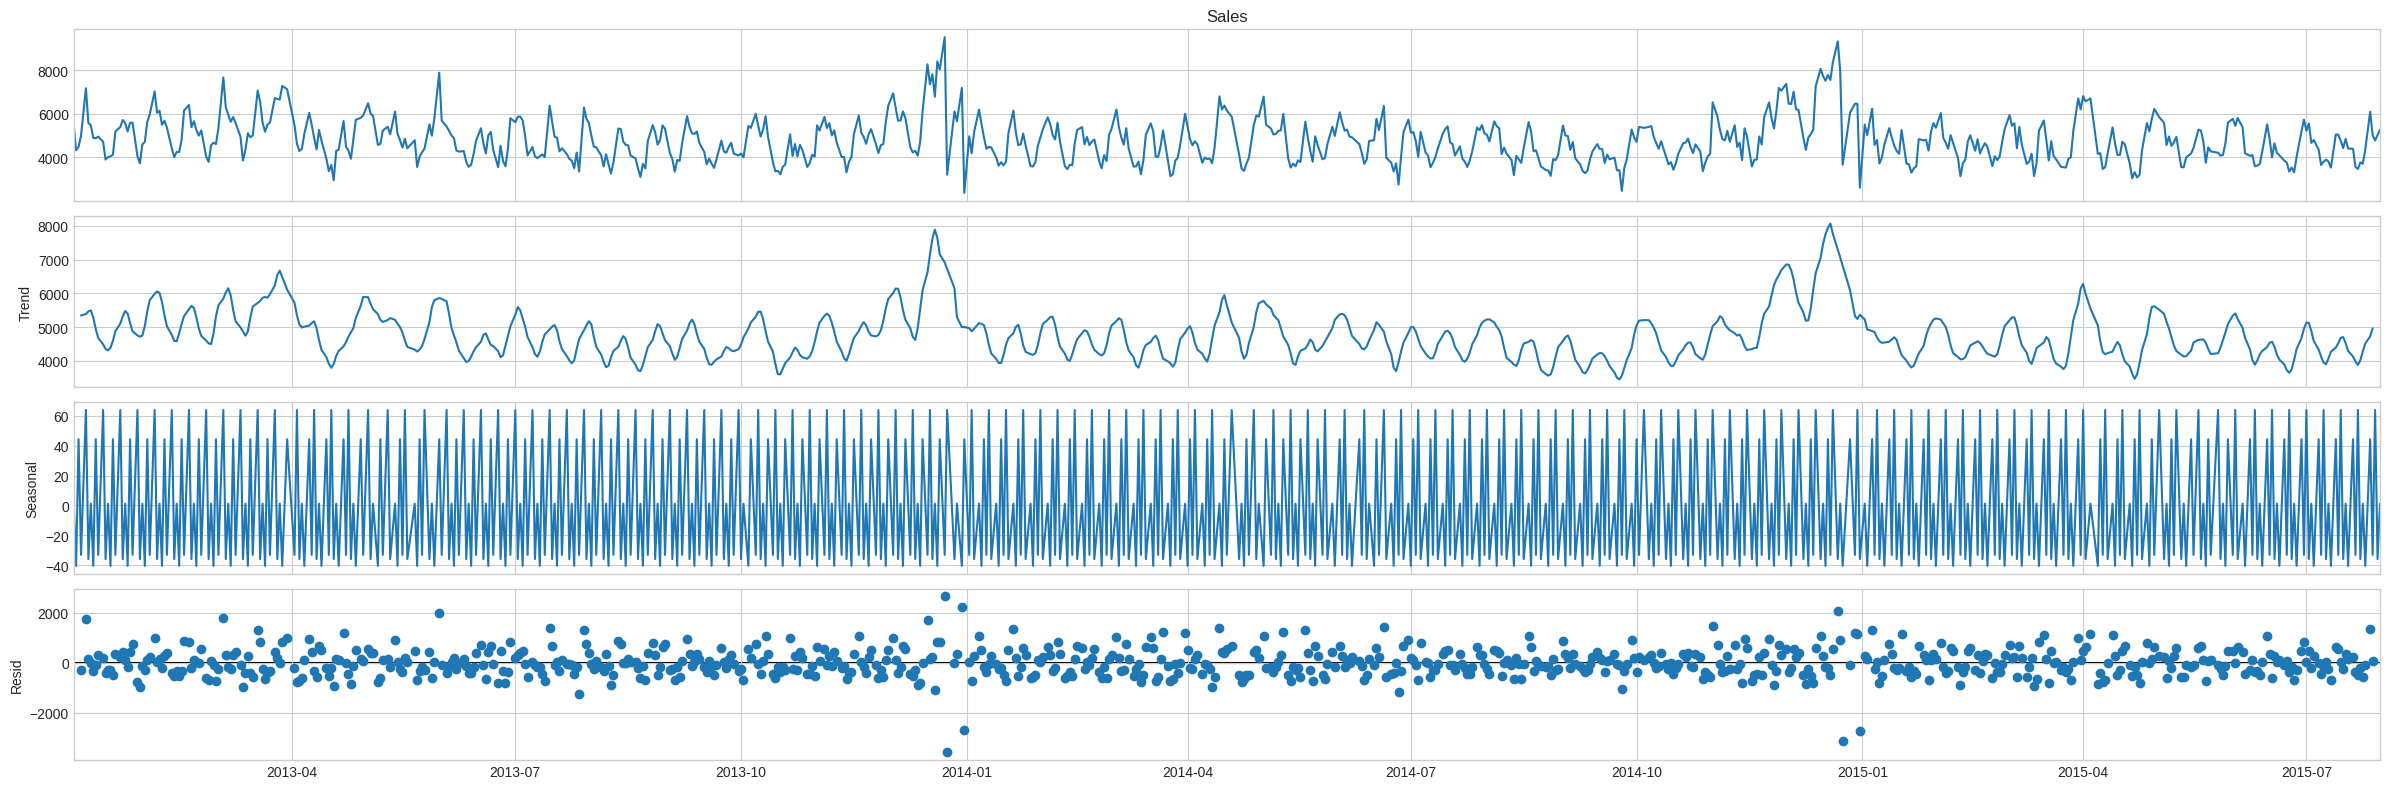

In [59]:
decomp_plot(store_open[1].Sales, model_type='additive', period=6)

There is seasonality present in the series. Also the sales already seem to be stationary.

### Splitting into train and test dataset:

We already eliminated the sundays because the store is closed. taking an assumption that our week will be of 6 days. Since, we need to predict the sales for 6 weeks we need to take sales of last 36 days as our test data.


In [60]:
train = store_open[1][:-36]
test = store_open[1][-36:]

### Normalizing Sales and Customets columns:

In [61]:
from sklearn.preprocessing import StandardScaler

def scaling(og_data,attri='Sales'):
    scaler = StandardScaler()#using standardscaler
    values = og_data[attri].values
    values=values.reshape(len(values),1)
    scaler_sale = scaler.fit(values)
    scaled_data = pd.Series(scaler.transform(values).reshape(-1),index=og_data.index)
    og_data[attri]=scaled_data
    return scaler_sale,og_data

scale_sales,train=scaling(train,'Sales')
scale_cust,train=scaling(train,'Customers')
train.head()

,Store,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,
2013-01-02,1,0.738551,1.071862,0,1,0,0,1,0,0,0
2013-01-03,1,-0.441094,0.119080,0,1,0,0,0,1,0,0
2013-01-04,1,-0.285181,0.553125,0,1,0,0,0,0,1,0
2013-01-05,1,0.215899,0.722509,0,1,0,0,0,0,0,1
2013-01-07,1,2.352595,2.310479,1,1,1,0,0,0,0,0


In [69]:
warnings.filterwarnings('ignore', '.* .*')

### Checking the stationarity:

In [62]:
stationarity(train,attr='Sales')

ADF test p value 5.761932581437353e-06
KPSS test p value 0.1
Series is stationary


In [63]:
stationarity(train,attr='Customers')

ADF test p value 0.0005775049285733798
KPSS test p value 0.032211199568965024
Stationarity is not conclusive


Both the columns Sales and Customers is stationary. We can create all **univariate** and **VAR** models

In [70]:
train.columns

Index(['Store', 'Sales', 'Customers', 'Promo', 'SchoolHoliday', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6'],
      dtype='object')

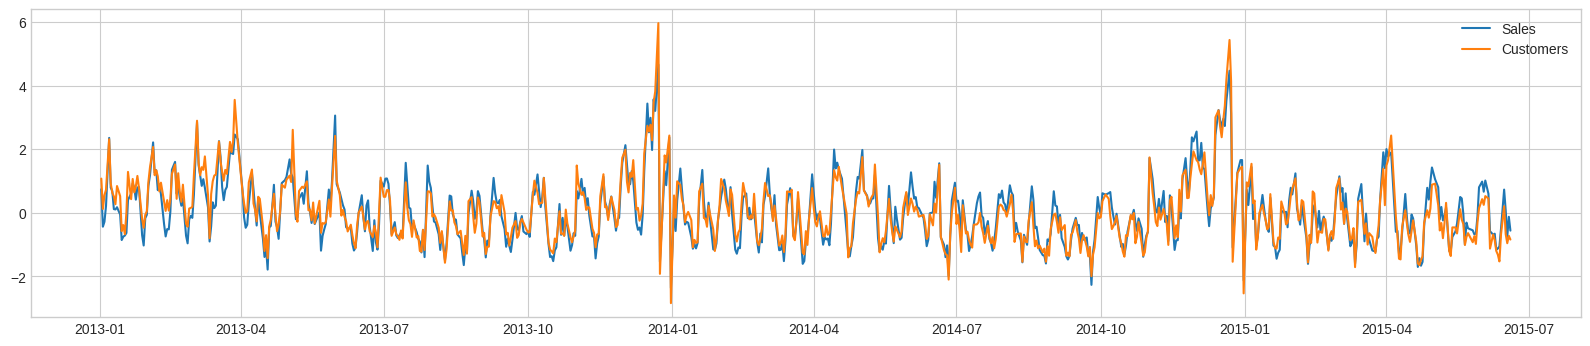

In [64]:
plt.figure(figsize=(20,4))
plt.plot(train[['Sales','Customers']],label=['Sales','Customers'])
plt.legend(loc='best')
plt.show()

In [65]:
johansen(store_open[1])

   max_eig_stat  trace_stat
0    150.820121  148.852325
1      1.967797    1.967797 

Critical value for Max eigen stat 90% 95% and 99%
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical value for Trace stat 90% 95% and 99%
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


Both sale and customers appear to move together and are cointegrated.

In [71]:
store_open[1].columns

Index(['Store', 'Sales', 'Customers', 'Promo', 'SchoolHoliday', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6'],
      dtype='object')

In [66]:
#Defining exogenous variable for train and test dataset
exog_train=train[['Promo', 'SchoolHoliday', 'DayOfWeek_1','DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5','DayOfWeek_6']]
exog_test=test[['Promo', 'SchoolHoliday', 'DayOfWeek_1','DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5','DayOfWeek_6']]

### Plotting ACF and PACF plot

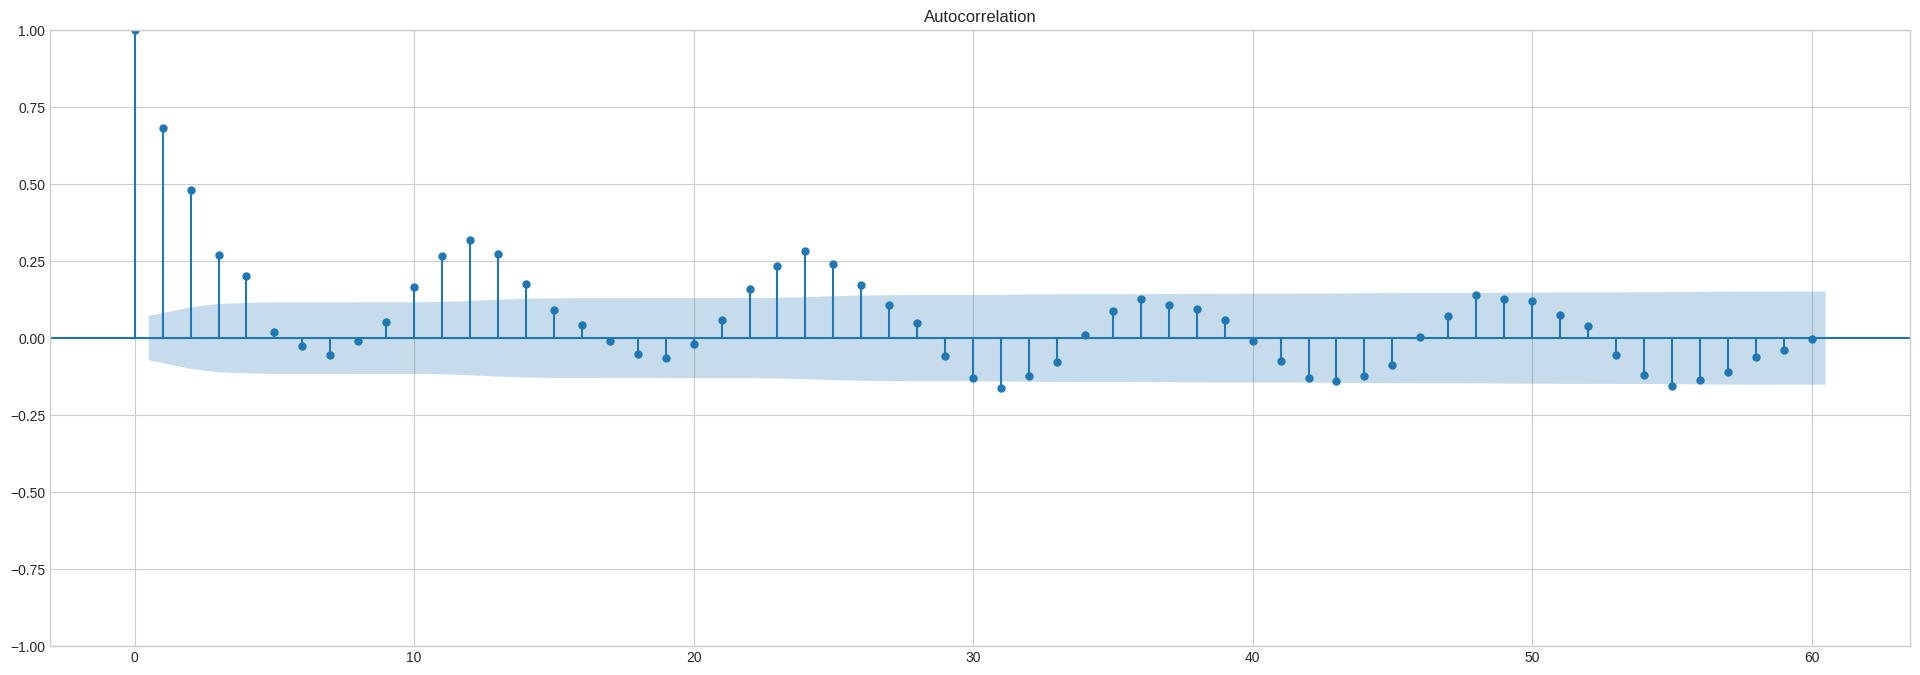

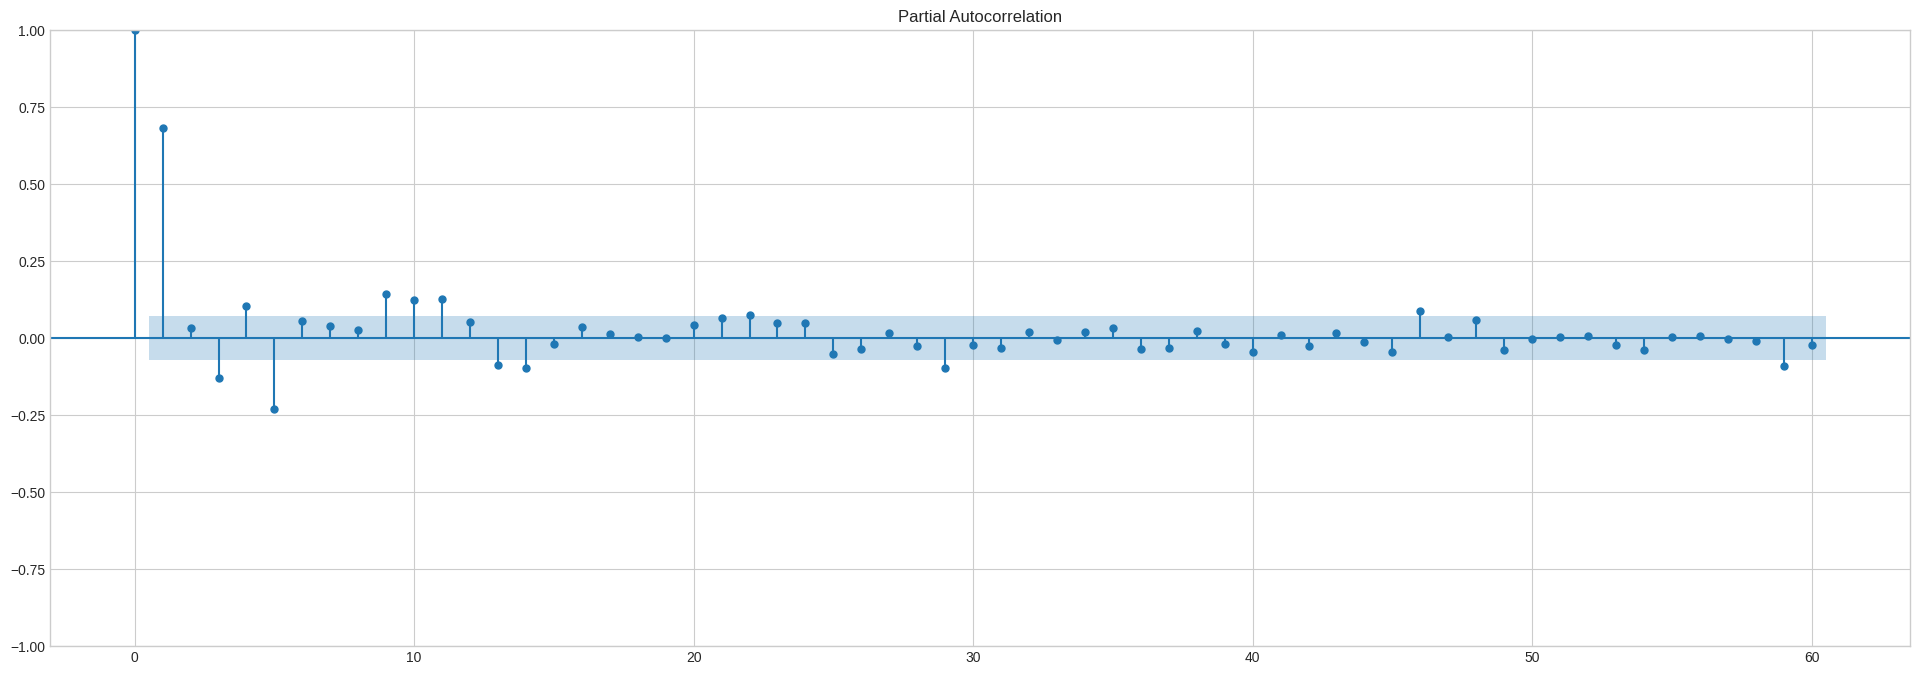

In [67]:
autocorr(train,lags=60,acf=True,pacf=True)

From the autocorrelation plots it seems that significant lags for p is 6 and q is 5 but still it is not very clear that exactly which lags should be considered

We can majorly use two methods for finding the best hyperparameters.

Using the autocorrelation plots
Cross validation with various possibilities of hyperparameters

### Using the estimation from correl plots:

Since the series is already stationary we will use p=5,d=0,q=4,P=1,D=0 and Q=1 and plot all the possible models

In [99]:
error1 =pd.DataFrame({'(p,d,q)':[],'AIC':[]})
order_list=[(5,0,4)]
for i in order_list:
    #Calling function to fit models
    model,pred=models(store_open[1],train,test,scale=scale_sales,plots=True,
                      ARIMA_m={'order':i},
                      ARIMAX={'order':i,'exog_train':exog_train,'exog_test':exog_test},
                     SARIMA={'order':i,'s_order':(1,0,1,6)},
                      SARIMAX_m={'order':i,'s_order':(1,0,1,6),'exog_train':exog_train,'exog_test':exog_test},
                     VAR={'order':(i[0],i[2])},
                    VARMAX_m={'order':(i[0],i[2]),'exog_train':exog_train,'exog_test':exog_test})

ARIMA model:
(p,d,q): (5, 0, 4)


ValueError: ignored

In [100]:
ARIMA_m={'order':(5, 0, 4)}
ARIMA_m['order']

(5, 0, 4)

In [101]:
#Functions for models
error1 =pd.DataFrame({'(p,d,q)':[],'AIC':[]})
order_list=[(5,0,4)]

error = pd.DataFrame({'Method':[],'MAPE':[],'RMSE':[]})#Dataframe to print model and their errors
model_fit={} #dictionary to store fitted models
plots=False
scale=scale_sales
ARIMA_m={'order':(5, 0, 4)}
og_data = store_open[1]

model=ARIMA(train['Sales'],order=ARIMA_m['order'])
model_fit['ARIMA']=model.fit()
aic=model_fit['ARIMA'].aic
predict=model_fit['ARIMA'].predict(train.index.min(),end=len(train)+len(test)-1)
#predict = scale.inverse_transform(predict)
#predict=pd.DataFrame(predict,index=og_data.index,columns=['Sales'])
#if (plots):
#  predicted_plot(train,test,scale,predict)
#mape,rmse = model_error(test,predict)
#error.loc[len(error)]=['ARIMA',mape,rmse]


In [102]:
predict = scale.inverse_transform(predict)

ValueError: ignored